# Heart Disease Artificial Intelligence Datathon 2021

**Baseline Code**

## 필독 TODO

* 해당 baseline 모델 및 오차 함수들은 Multiclass 및 One-Hot 라벨을 가정하고 만들어졌습니다.

* 따라서 그대로 사용하시기보단 loss function 튜닝이 필요합니다. (PR로 만들어주세요.)

* 그리고 dataset root path 설정해야 합니다.

# Runtime Preparation

## View Runtime Information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0 or gpu_info.find('not found') >= 0:
    device = 'cpu'; print('Not connected to a GPU')
else: device = 'cuda'; print(gpu_info)

Thu Dec  2 08:56:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   37C    P8    20W / 230W |     10MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:02:00.0 Off |                  Off |
| 30%   

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f'Your runtime has {ram_gb:.1f} gigabytes of available RAM\n'
      f'{"Not" if ram_gb < 20 else "You are"} using a high-RAM runtime!')

Your runtime has 67.2 gigabytes of available RAM
You are using a high-RAM runtime!


In [3]:
import os
import sys
import platform
import torch
print(f"OS version: \t\t{platform.platform()}\n"
      f"Python version:\t\t{sys.version.replace(chr(10), str())}\n"
      f"Torch version:\t\t{torch.__version__}\n"
      f"Torch device:\t\t{device}")

OS version: 		Linux-5.11.0-40-generic-x86_64-with-debian-buster-sid
Python version:		3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
Torch version:		1.9.0
Torch device:		cuda


## Prepare device and library

In [4]:
device = torch.device(device)


In [5]:
# After all installation, import all libraries used.

!pip install torchinfo
!pip install pyclean
!pyclean .

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, RandomSampler, DataLoader
from torchvision import transforms
import torchinfo


Cleaning directory .
Total 15 files, 2 directories removed.


# Dataset Preparation

## Make Dataset Class

In [6]:
from utils.dataset import ImageList

## Instantiate Dataset

In [7]:
root: str = "../echocardiography/"

num_classes = 2
num_channel = 1

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256),
                                interpolation=transforms.InterpolationMode.NEAREST),
                                ])

train_a2c = os.path.join(root, 'train', 'A2C')
train_a2c = ImageList.from_path(train_a2c, transform=transform, target_transform=transform)

train_a4c = os.path.join(root, 'train', 'A4C')
train_a4c = ImageList.from_path(train_a4c, transform=transform, target_transform=transform)

val_a2c = os.path.join(root, 'validation', 'A2C')
val_a2c = ImageList.from_path(val_a2c, transform=transform, target_transform=transform)

val_a4c = os.path.join(root, 'validation', 'A4C')
val_a4c = ImageList.from_path(val_a4c, transform=transform, target_transform=transform)

train_datasets = ConcatDataset([train_a2c, train_a4c])
val_datasets = ConcatDataset([val_a2c, val_a4c])


# Network Preparation

## Segmentation Network

* **DeepLabV3 + Resnet101**: Baseline Model

* **U-Net**

* **Inception U-Net**

* **RefineNet**


In [8]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation import deeplabv3_resnet101

from models.unet import UNet, InceptionUNet
from models.refinenet import refinenet50, refinenet101, refinenet152, rf_lw50, rf_lw101, rf_lw152

In [9]:
# # Baseline: DeeplabV3 + ResNet101

# # Pretrained Model
net = deeplabv3_resnet101(pretrained=True, progress=False)
net.backbone.conv1 = nn.Conv2d(num_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
net.classifier = DeepLabHead(2048, num_classes)
# net.aux_classifier = nn.Sequential()
net.aux_classifier = FCNHead(1024, num_classes)

# # Non-pretrained Model
# net = deeplabv3_resnet101(pretrained=False, num_classes=6)

trainable_backbone_layers = ['layer4']
for n, p in net.named_parameters():
    if n.startswith('backbone') and n.split('.')[1] not in trainable_backbone_layers:
        p.requires_grad = False

net.to(device)
if torch.cuda.device_count() > 1:
    net = torch.nn.DataParallel(net)
    net.to(device)

print(torchinfo.summary(net, (1, num_channel, 256, 256)))

Layer (type:depth-idx)                                  Output Shape              Param #
DataParallel                                            --                        --
├─DeepLabV3: 1-1                                        [1, 2, 256, 256]          --
├─DeepLabV3: 1                                          --                        --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 32, 32]         --
│    └─IntermediateLayerGetter: 2                       --                        --
│    │    └─Conv2d: 3-1                                 [1, 64, 128, 128]         (3,136)
│    │    └─BatchNorm2d: 3-2                            [1, 64, 128, 128]         (128)
│    │    └─ReLU: 3-3                                   [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 64, 64]           --
│    │    └─Sequential: 3-5                             [1, 256, 64, 64]          (215,808)
│    │    └─Sequential: 3-6                  

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Loss Network

* **Binary Cross Entropy**

* **Dice Coefficient**

* **Intersection over Union Score**

- More Multi-Label Segmentation Losses: https://jeune-research.tistory.com/entry/Loss-Functions-for-Image-Segmentation-Region-Based-Losses

- See also: https://smp.readthedocs.io/en/latest/losses.html

In [10]:
from models.loss import BCEDiceIoUWithLogitsLoss2d, BCEDiceIoULoss2d

# Training

## Set Hyper Parameters

In [11]:
from utils.lr_scheduler import CosineAnnealingWarmUpRestarts

# Lazy-eval iterable dataset: do not set sampler or shuffle options
num_epoch = 100

batch_size = 35
num_workers = 1

loss_function = BCEDiceIoUWithLogitsLoss2d()
optimizer_class = torch.optim.Adam
optimizer_config = {'lr': 1e-6}
scheduler_class = CosineAnnealingWarmUpRestarts
scheduler_config = {'T_0': 10, 'T_mult': 2, 'eta_max': 1e-3, 'T_up': 3, 'gamma': 0.5}

## Train and Evaluate

In [12]:
train_loader = DataLoader(train_datasets, batch_size, num_workers=num_workers, drop_last=False)
val_loader = DataLoader(val_datasets, batch_size, num_workers=num_workers, drop_last=False)

optimizer = optimizer_class(net.parameters(), **optimizer_config)
lr_scheduler = scheduler_class(optimizer, **scheduler_config)


def load_state_dict(d):
    net.load_state_dict(d['model'])
    optimizer.load_state_dict(d['optimizer'])
    lr_scheduler.load_state_dict(d['lr_scheduler'])


def state_dict():
    from collections import OrderedDict
    d = OrderedDict()
    d['model'] = net.state_dict()
    d['optimizer'] = optimizer.state_dict()
    d['lr_scheduler'] = lr_scheduler.state_dict()
    return d


In [13]:
import uuid
from utils.training import train_one_epoch

try:
    print(f"Re-using session: {session_name}")
except NameError:
    session_name = str(uuid.uuid4())
    print(f"Generating session: {session_name}")

checkpoint_dir = f'checkpoint/{session_name}'
os.makedirs(checkpoint_dir, exist_ok=True)

for ep in range(num_epoch):
    train_one_epoch(net, loss_function, optimizer, lr_scheduler, train_loader, val_loader, device, ep, warmup_start=False)
    # Take care of computational resource.
    if ep == num_epoch - 1:
        torch.save(state_dict(), os.path.join(checkpoint_dir, '{}.pt').format(ep))

Generating session: 4dcad4f1-9f87-4e77-89ea-8ff9199854f9


Iteration 0 train loss: 0.5498


Iteration 0 eval loss: 0.2208


Iteration 1 train loss: 0.1810


Iteration 1 eval loss: 0.1076


Iteration 2 train loss: 0.1136


Iteration 2 eval loss: 0.0749


Iteration 3 train loss: 0.0845


Iteration 3 eval loss: 0.0589


Iteration 4 train loss: 0.0706


Iteration 4 eval loss: 0.0509


Iteration 5 train loss: 0.0628


Iteration 5 eval loss: 0.0458


Iteration 6 train loss: 0.0574


Iteration 6 eval loss: 0.0429


Iteration 7 train loss: 0.0538


Iteration 7 eval loss: 0.0405


Iteration 8 train loss: 0.0512


Iteration 8 eval loss: 0.0393


Iteration 9 train loss: 0.0493


Iteration 9 eval loss: 0.0388


Iteration 10 train loss: 0.0483


Iteration 10 eval loss: 0.0385


Iteration 11 train loss: 0.0474


Iteration 11 eval loss: 0.0380


Iteration 12 train loss: 0.0468


Iteration 12 eval loss: 0.0377


Iteration 13 train loss: 0.0467


Iteration 13 eval loss: 0.0376


Iteration 14 train loss: 0.0457


Iteration 14 eval loss: 0.0348


Iteration 15 train loss: 0.0423


Iteration 15 eval loss: 0.0312


Iteration 16 train loss: 0.0378


Iteration 16 eval loss: 0.0285


Iteration 17 train loss: 0.0335


Iteration 17 eval loss: 0.0272


Iteration 18 train loss: 0.0302


Iteration 18 eval loss: 0.0271


Iteration 19 train loss: 0.0273


Iteration 19 eval loss: 0.0279


Iteration 20 train loss: 0.0254


Iteration 20 eval loss: 0.0274


Iteration 21 train loss: 0.0254


Iteration 21 eval loss: 0.0246


Iteration 22 train loss: 0.0236


Iteration 22 eval loss: 0.0231


Iteration 23 train loss: 0.0222


Iteration 23 eval loss: 0.0238


Iteration 24 train loss: 0.0225


Iteration 24 eval loss: 0.0244


Iteration 25 train loss: 0.0223


Iteration 25 eval loss: 0.0221


Iteration 26 train loss: 0.0205


Iteration 26 eval loss: 0.0236


Iteration 27 train loss: 0.0232


Iteration 27 eval loss: 0.0206


Iteration 28 train loss: 0.0178


Iteration 28 eval loss: 0.0209


Iteration 29 train loss: 0.0175


Iteration 29 eval loss: 0.0223


Iteration 30 train loss: 0.0188


Iteration 30 eval loss: 0.0217


Iteration 31 train loss: 0.0175


Iteration 31 eval loss: 0.0225


Iteration 32 train loss: 0.0165


Iteration 32 eval loss: 0.0211


Iteration 33 train loss: 0.0154


Iteration 33 eval loss: 0.0194


Iteration 34 train loss: 0.0151


Iteration 34 eval loss: 0.0194


Iteration 35 train loss: 0.0149


Iteration 35 eval loss: 0.0201


Iteration 36 train loss: 0.0149


Iteration 36 eval loss: 0.0215


Iteration 37 train loss: 0.0143


Iteration 37 eval loss: 0.0219


Iteration 38 train loss: 0.0137


Iteration 38 eval loss: 0.0221


Iteration 39 train loss: 0.0136


Iteration 39 eval loss: 0.0223


Iteration 40 train loss: 0.0144


Iteration 40 eval loss: 0.0233


Iteration 41 train loss: 0.0148


Iteration 41 eval loss: 0.0234


Iteration 42 train loss: 0.0143


Iteration 42 eval loss: 0.0250


Iteration 43 train loss: 0.0147


Iteration 43 eval loss: 0.0251


Iteration 44 train loss: 0.0146


Iteration 44 eval loss: 0.0218


Iteration 45 train loss: 0.0131


Iteration 45 eval loss: 0.0199


Iteration 46 train loss: 0.0130


Iteration 46 eval loss: 0.0195


Iteration 47 train loss: 0.0129


Iteration 47 eval loss: 0.0196


Iteration 48 train loss: 0.0126


Iteration 48 eval loss: 0.0194


Iteration 49 train loss: 0.0124


Iteration 49 eval loss: 0.0194


Iteration 50 train loss: 0.0123


Iteration 50 eval loss: 0.0195


Iteration 51 train loss: 0.0122


Iteration 51 eval loss: 0.0199


Iteration 52 train loss: 0.0121


Iteration 52 eval loss: 0.0203


Iteration 53 train loss: 0.0127


Iteration 53 eval loss: 0.0204


Iteration 54 train loss: 0.0133


Iteration 54 eval loss: 0.0204


Iteration 55 train loss: 0.0131


Iteration 55 eval loss: 0.0196


Iteration 56 train loss: 0.0118


Iteration 56 eval loss: 0.0188


Iteration 57 train loss: 0.0109


Iteration 57 eval loss: 0.0189


Iteration 58 train loss: 0.0107


Iteration 58 eval loss: 0.0191


Iteration 59 train loss: 0.0105


Iteration 59 eval loss: 0.0190


Iteration 60 train loss: 0.0103


Iteration 60 eval loss: 0.0188


Iteration 61 train loss: 0.0101


Iteration 61 eval loss: 0.0185


Iteration 62 train loss: 0.0099


Iteration 62 eval loss: 0.0183


Iteration 63 train loss: 0.0099


Iteration 63 eval loss: 0.0183


Iteration 64 train loss: 0.0098


Iteration 64 eval loss: 0.0183


Iteration 65 train loss: 0.0098


Iteration 65 eval loss: 0.0183


Iteration 66 train loss: 0.0098


Iteration 66 eval loss: 0.0183


Iteration 67 train loss: 0.0097


Iteration 67 eval loss: 0.0183


Iteration 68 train loss: 0.0097


Iteration 68 eval loss: 0.0183


Iteration 69 train loss: 0.0097


Iteration 69 eval loss: 0.0183


Iteration 70 train loss: 0.0096


Iteration 70 eval loss: 0.0183


Iteration 71 train loss: 0.0096


Iteration 71 eval loss: 0.0183


Iteration 72 train loss: 0.0096


Iteration 72 eval loss: 0.0183


Iteration 73 train loss: 0.0096


Iteration 73 eval loss: 0.0185


Iteration 74 train loss: 0.0096


Iteration 74 eval loss: 0.0185


Iteration 75 train loss: 0.0095


Iteration 75 eval loss: 0.0186


Iteration 76 train loss: 0.0094


Iteration 76 eval loss: 0.0186


Iteration 77 train loss: 0.0092


Iteration 77 eval loss: 0.0188


Iteration 78 train loss: 0.0091


Iteration 78 eval loss: 0.0191


Iteration 79 train loss: 0.0093


Iteration 79 eval loss: 0.0196


Iteration 80 train loss: 0.0096


Iteration 80 eval loss: 0.0227


Iteration 81 train loss: 0.0102


Iteration 81 eval loss: 0.0217


Iteration 82 train loss: 0.0109


Iteration 82 eval loss: 0.0211


Iteration 83 train loss: 0.0107


Iteration 83 eval loss: 0.0200


Iteration 84 train loss: 0.0108


Iteration 84 eval loss: 0.0199


Iteration 85 train loss: 0.0092


Iteration 85 eval loss: 0.0213


Iteration 86 train loss: 0.0094


Iteration 86 eval loss: 0.0230


Iteration 87 train loss: 0.0099


Iteration 87 eval loss: 0.0238


Iteration 88 train loss: 0.0093


Iteration 88 eval loss: 0.0223


Iteration 89 train loss: 0.0098


Iteration 89 eval loss: 0.0241


Iteration 90 train loss: 0.0093


Iteration 90 eval loss: 0.0288


Iteration 91 train loss: 0.0104


Iteration 91 eval loss: 0.0229


Iteration 92 train loss: 0.0096


Iteration 92 eval loss: 0.0230


Iteration 93 train loss: 0.0097


Iteration 93 eval loss: 0.0228


Iteration 94 train loss: 0.0099


Iteration 94 eval loss: 0.0223


Iteration 95 train loss: 0.0091


Iteration 95 eval loss: 0.0241


Iteration 96 train loss: 0.0084


Iteration 96 eval loss: 0.0229


Iteration 97 train loss: 0.0082


Iteration 97 eval loss: 0.0212


Iteration 98 train loss: 0.0083


Iteration 98 eval loss: 0.0209


Iteration 99 train loss: 0.0086


Iteration 99 eval loss: 0.0259


## Test

In [14]:
from utils.evaluation import all_together, draw_confusion_matrix

Model Architecture:      DataParallel
Binary Cross Entropy:    0.04069
Dice-Coefficient:        0.99075
Intersection over Union: 0.98167
Pixel-Wise Accuracy:     99.0750%


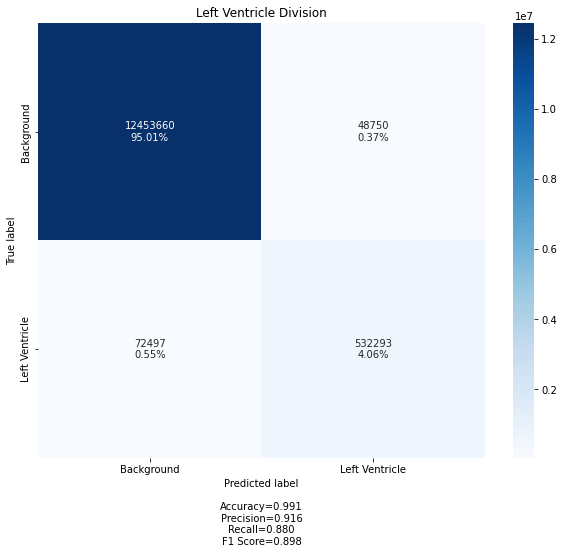

In [15]:
# TBD

label_names = [
    "Background",
    "Left Ventricle",
]

val_a2c = os.path.join(root, 'validation', 'A2C')
val_a2c = ImageList.from_path(val_a2c, transform=transform, target_transform=transform)

val_a4c = os.path.join(root, 'validation', 'A4C')
val_a4c = ImageList.from_path(val_a4c, transform=transform, target_transform=transform)

val_datasets = ConcatDataset([val_a2c, val_a4c])

val_loader = DataLoader(val_datasets, batch_size, num_workers=num_workers, drop_last=False)

_, _, _, _, cm = all_together(net, val_loader, device=device, verbose=True)
draw_confusion_matrix(
    cm[:2, :2], label_names, label_names,
    figsize=(10, 8), title="Left Ventricle Division"
)